In [1]:
from scipy.stats import fisher_exact
import pandas as pd
import pyranges as pr
import gzip

# === CONFIGURATION ===
CLUSTER_FILE = "annotated_hypo_clusters.csv"
GENOME_FILE = "/data/cephfs-1/work/groups/kühnen/users/cama15_c/metastable_epiallele_analysis/10_samples_work/full_genome_cpgs_annotated.csv"
OUTPUT_FILE = "hypo_cluster_feature_enrichment_scores.csv"

# === LOAD DATA ===
cluster_df = pd.read_csv(CLUSTER_FILE)
full_df = pd.read_csv(GENOME_FILE)

# Drop methylation fraction and coverage columns
cluster_df = cluster_df.loc[:, ~cluster_df.columns.str.contains("_frac|_cov")]
full_df = full_df.loc[:, ~full_df.columns.str.contains("_frac|_cov")]

# Identify features: Near_* and Overlaps_* boolean columns
feature_cols = [col for col in cluster_df.columns if col.startswith("Near_") or col.startswith("Overlaps_")]

# Build a fast lookup set of cluster CpG positions
results = []

for cluster_id in sorted(cluster_df["Cluster"].unique()):
    cluster_subset = cluster_df[cluster_df["Cluster"] == cluster_id]
    cluster_sites = set(zip(cluster_subset["Chromosome"], cluster_subset["Start"], cluster_subset["End"]))

    # Create indicator column in the full genome: is this CpG in the cluster?
    full_df["in_cluster"] = full_df.apply(
        lambda row: (row["Chromosome"], row["Start"], row["End"]) in cluster_sites,
        axis=1
    )

    for feature in feature_cols:
        # Build contingency table
        in_cluster_true = full_df[(full_df["in_cluster"]) & (full_df[feature] == True)].shape[0]
        in_cluster_false = full_df[(full_df["in_cluster"]) & (full_df[feature] == False)].shape[0]
        not_cluster_true = full_df[(~full_df["in_cluster"]) & (full_df[feature] == True)].shape[0]
        not_cluster_false = full_df[(~full_df["in_cluster"]) & (full_df[feature] == False)].shape[0]

        contingency = [[in_cluster_true, in_cluster_false], [not_cluster_true, not_cluster_false]]

        try:
            odds_ratio, p_value = fisher_exact(contingency)
        except ValueError:
            odds_ratio, p_value = float('nan'), float('nan')

        results.append({
            "Cluster": cluster_id,
            "Feature": feature,
            "In_Cluster_True": in_cluster_true,
            "In_Cluster_False": in_cluster_false,
            "Not_Cluster_True": not_cluster_true,
            "Not_Cluster_False": not_cluster_false,
            "Odds_Ratio": odds_ratio,
            "Fisher_p": p_value
        })

# Convert to DataFrame and sort
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(["Cluster", "Fisher_p"])

# Save to CSV
results_df.to_csv(OUTPUT_FILE, index=False)

print(f"Enrichment results saved to: {OUTPUT_FILE}")

/tmp/ipykernel_2803997/3676593830.py:13: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  full_df = pd.read_csv(GENOME_FILE)


Enrichment results saved to: hypo_cluster_feature_enrichment_scores.csv


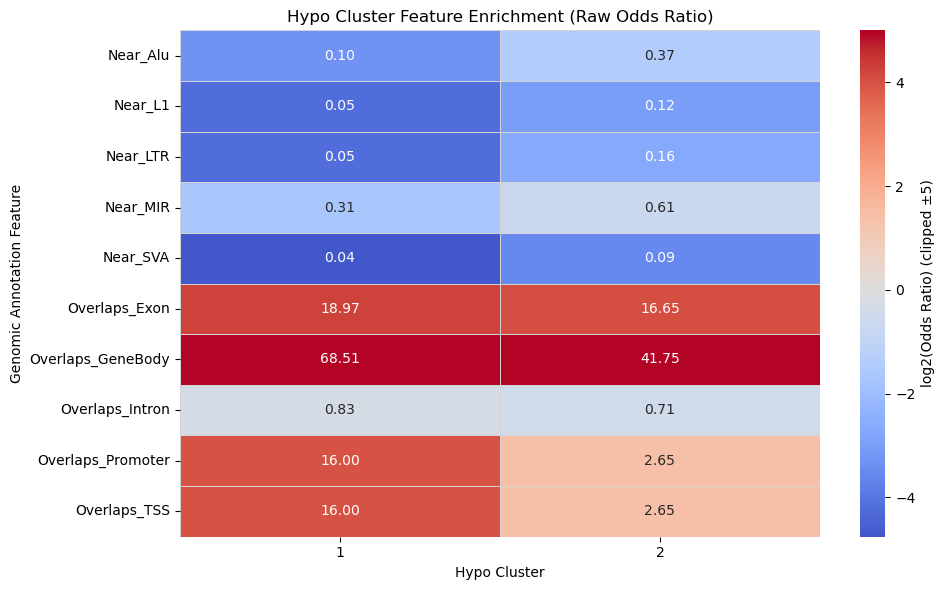

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv("hypo_cluster_feature_enrichment_scores.csv")

# Pivot
pivot_or = df.pivot(index="Feature", columns="Cluster", values="Odds_Ratio")
pivot_p = df.pivot(index="Feature", columns="Cluster", values="Fisher_p")

# Prepare log2 color values (mask only inf, not zero)
log_or = np.log2(pivot_or.replace(0, np.nan))
log_or = log_or.replace([np.inf, -np.inf], np.nan)
log_or_clipped = log_or.clip(lower=-5, upper=5)
plot_data = log_or_clipped.fillna(0)

# Annotation matrix: display raw OR, except if p > 0.001 AND OR ≠ 0
annot_matrix = pivot_or.copy().astype(object)
for row in annot_matrix.index:
    for col in annot_matrix.columns:
        pval = pivot_p.loc[row, col]
        or_val = pivot_or.loc[row, col]
        if pd.notna(pval) and pval > 0.001 and or_val != 0.0:
            annot_matrix.loc[row, col] = "NS"
        elif np.isinf(or_val):
            annot_matrix.loc[row, col] = "inf"
        else:
            annot_matrix.loc[row, col] = f"{or_val:.2f}"

# Plot
plt.figure(figsize=(10, max(6, len(plot_data) * 0.4)))
sns.heatmap(
    plot_data,
    annot=annot_matrix,
    fmt='',
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    linecolor='lightgrey',
    cbar_kws={'label': 'log2(Odds Ratio) (clipped ±5)'}
)
plt.title("Hypo Cluster Feature Enrichment (Raw Odds Ratio)")
plt.ylabel("Genomic Annotation Feature")
plt.xlabel("Hypo Cluster")
plt.tight_layout()
plt.savefig("hypo_cluster_enrichment_heatmap.pdf", bbox_inches='tight')
plt.savefig("hypo_cluster_enrichment_heatmap.svg", bbox_inches='tight')
plt.show()